# Введение в анализ данных
## НИУ ВШЭ, 2019-2020 учебный год

### Домашнее задание №4

Задание выполнил: Дмитрий Монахов

### Общая информация

__Дата выдачи:__ 24.05.2020

__Дедлайн:__ 23:59 07.06.2020


### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
min(\text{points}, 19)  \times 10 / 19,
$$

где points — количество баллов за обязательную часть, которое вы набрали. Максимальное число баллов, которое можно получить за обязательную часть — 19, а максимальное число дополнительных баллов, которые пойдут в бонус — 1.

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Инвайт для группы ИАД-4: zG1cIyT

Перед отправкой перезагрузите ноутбук и проверьте, что все ячейки могут быть последовательно выполнены. Ноутбук должен запускаться с использованием python 3.6+

In [449]:
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample

## Random Forest своими руками (4 балла)

Реализуйте алгоритм случайного леса. В соответствии с построением алгоритма, ваша реализация должна сочетать в себе метод бэггинга и метод случайных подмножеств. Также она должна работать для двух типов задач: как для задачи регрессии, так и для задачи классификации.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn`.*

In [450]:
def vote(line):
    return np.argmax(np.bincount(line))

In [451]:
class RandomForest:
    def __init__(self, n_estimators, max_depth, max_features='sqrt', task_type='regression'):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        max_features - maximum features for each split in DecisionTree from sklearn
        task_type - 'regression' or 'classification'
        """
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.task_type = task_type
        
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        
        self.X = X_train
        self.y = y_train
        trees = []
        
        if self.task_type == 'regression':
        
            for i in range(self.n_estimators):
                
                X_train, y_train = resample(self.X, self.y)
                tree = DecisionTreeRegressor(max_depth = self.max_depth, max_features=self.max_features)
                tree.fit(X_train, y_train)
                
                trees.append(tree)
                
            self.trees = trees
            
        if self.task_type == 'classification':
            
            for i in range(self.n_estimators):
                
                X_train, y_train = resample(self.X, self.y)
                tree = DecisionTreeClassifier(max_depth = self.max_depth, max_features=self.max_features)
                tree.fit(X_train, y_train)
                
                trees.append(tree)
                
            self.trees = trees
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        
        self.X_test = X_test
        
        if self.task_type == 'regression':
            
            res = np.array([tree.predict(self.X_test) for tree in self.trees])
            y_pred = np.mean(res, axis=0)
            
        if self.task_type == 'classification':
            
            res = np.array([tree.predict(self.X_test) for tree in self.trees])
            y_pred = np.apply_along_axis(vote, 0, res)

        return y_pred

Проверьте вашу реализацию на задаче регрессии. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10.25 **(не меняйте параметры сида)**.

In [452]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [453]:
np.random.seed(19052019)

rf = RandomForest(600, 15, 'sqrt', 'regression')
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

10.09021044758938

Проверьте вашу реализацию на задаче классификации. Подберите оптимальные гиперпараметры, чтобы получить accuracy > 0.83 **(не меняйте параметры сида)**.

In [454]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [455]:
np.random.seed(19052019)

rf = RandomForest(600, 10, 'sqrt', 'classification')
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.9440559440559441

## Градиентный бустинг своими руками (5 + 1* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Однако чтобы получить дополнительный 1 балл вам нужно реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [456]:
# это может помочь вам для поиска оптимальных gamma

from scipy.optimize import minimize

In [457]:
def to_opt(gamma, y, z, pred):
    return (1 / len(y)) * sum((y - (z + gamma * pred)) ** 2)

In [458]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1, find_gamma: bool = False):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        find_gamma - find optimal weight or not
        """
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.find_gamma = find_gamma
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        self.X_train = X_train
        self.y_train = y_train
        
        trees = []
        gammas = [1]
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(self.X_train, self.y_train)
        trees.append(tree)
        
        for i in range(1, self.n_estimators):
            
            raw = [self.learning_rate * tree.predict(self.X_train) for tree in trees]
            
            if self.find_gamma:
                z = sum(np.array(gammas).reshape(len(gammas), 1) * raw)
            else:
                z = sum([self.learning_rate * tree.predict(self.X_train) for tree in trees])
                
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(self.X_train, (self.y_train - z))
            
            if self.find_gamma:
                gamma = minimize(to_opt, 0.5, args=(self.y_train, z, tree.predict(X_train))).x
                gammas.append(gamma)
                
            trees.append(tree)
            
        self.trees = trees
        self.gammas = np.array(gammas)
    
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        
        pred_raw = [self.learning_rate * tree.predict(X_test) for tree in self.trees]
        
        if self.find_gamma:
            y_pred = sum(self.gammas.reshape(len(self.gammas), 1) * pred_raw)
        else:
            y_pred = sum(pred_raw)
            
        return y_pred

Проверьте вашу реализацию. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10 как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**.

In [459]:
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [460]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=75, max_depth=6, learning_rate=0.19)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [461]:
mean_squared_error(y_test, y_pred)

9.63424772570338

Теперь с поиском оптимального шага:

In [462]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=70, max_depth=6, learning_rate=0.2, find_gamma=True)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

mean_squared_error(y_test, y_pred)

9.998291992662564

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да 

## Ансамблевые методы (10 баллов)

Сопровождайте код изображениями и комментариями. Не игнорируйте вопросы, ваши выводы тоже оцениваются. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше. Не забывайте подписывать графики и будет вам счастье!

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [464]:
data = pd.read_csv('diabetes.csv')

**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In [465]:
(data == 0).any()

Pregnancies                  True
Glucose                      True
BloodPressure                True
SkinThickness                True
Insulin                      True
BMI                          True
DiabetesPedigreeFunction    False
Age                         False
Outcome                      True
dtype: bool

Кажется, колонки в которых не должно быть нулей - BloodPressure, SkinThickness, Insulin, BMI, Glucose. В колонках Pregnancies и Outcome нули выглядят оправдано - первый признак объективно может принимать значение 0, а второй - бинарный признак со значениями 0 и 1.

In [466]:
to_change = ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Glucose']

In [467]:
data[to_change] = (data[to_change] == 0) * data[to_change].mean() + data[to_change]

**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

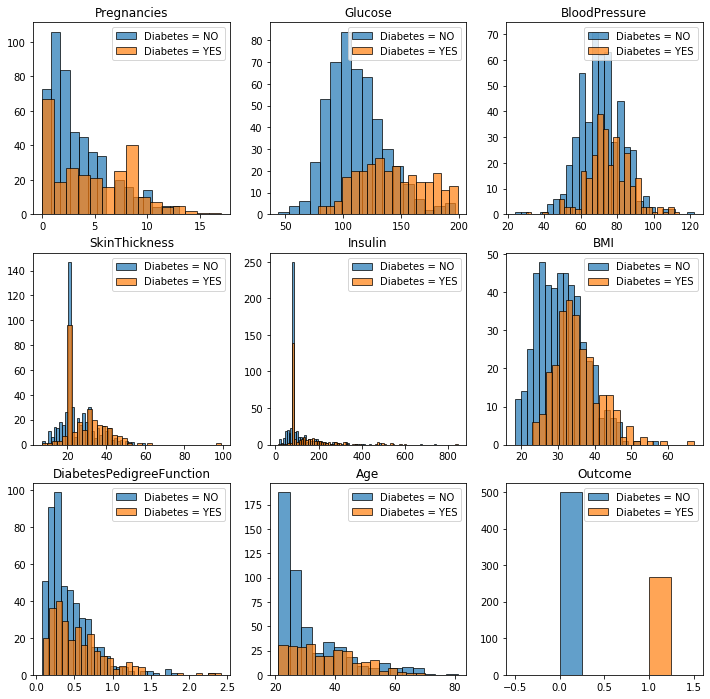

In [468]:
col_for_plot = np.array(data.columns).reshape(3,3)
fig,ax = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        iqr = np.percentile(data[col_for_plot[i][j]], 75) - np.percentile(data[col_for_plot[i][j]], 25)
        h = 2 * iqr * len(data) ** (- 1/ 3)
        bins = (data[col_for_plot[i][j]].max() - data[col_for_plot[i][j]].min()) / h
        ax[i][j].hist(data[data['Outcome'] == 0][col_for_plot[i][j]], label='Diabetes = NO', 
                      ec='black', alpha=0.7, bins=int(bins))
        ax[i][j].hist(data[data['Outcome'] == 1][col_for_plot[i][j]], label='Diabetes = YES', 
                      ec='black', alpha=0.7, bins=int(bins))
        ax[i][j].set_title(col_for_plot[i][j])
        ax[i][j].legend()
plt.show()

**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите `BaggingClassifier` на деревьях (поставьте параметр `'base_estimator' = DecisionTreeClassifier()`) и `RandomForest`. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*Подсказка: создайте отдельную функцию для вывода метрик качества.*

In [472]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [473]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [474]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Outcome', axis=1), data['Outcome'],
                                                    test_size=0.3, random_state=6)

In [475]:
def metrics(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
    print(f'Precision = {precision_score(y_test, y_pred)}')
    print(f'Recall = {recall_score(y_test, y_pred)}')

In [476]:
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=6)
rf_skl = RandomForestClassifier(n_estimators=10, random_state=6)

In [477]:
bc.fit(X_train, y_train)
rf_skl.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=6)

In [478]:
metrics(bc)

Accuracy = 0.7748917748917749
Precision = 0.6710526315789473
Recall = 0.6538461538461539


In [479]:
metrics(rf_skl)

Accuracy = 0.7575757575757576
Precision = 0.6571428571428571
Recall = 0.5897435897435898


В алгоритме random forest в sklearn реализован метод случайный подмножеств, а в bagging classifier - нет, его надо отдельно включить в параметрах дерева. То есть случайный лес при построении деревьев на каждом разбиении выбирает случайные признаки из всего датасета - в данном случае sqrt(max_features) и выбирает оптимальное разбиение только из этих признаков, а bagging classifier при построении дерева на каждом шаге использует все признаки. В теории из-за метода случайных подмножеств качество случайного леса должно быть выше - корреляция между деревьями получается ниже, что помогает уменьшить разброс итоговой модели. Однако в этом случае качество bagging classifier получилось выше. Наверное, так происходит из-за маленького количества признаков в датасете. 

**4. (2 балл)** Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Какие выводы вы можете сделать?

In [480]:
from sklearn.metrics import roc_auc_score

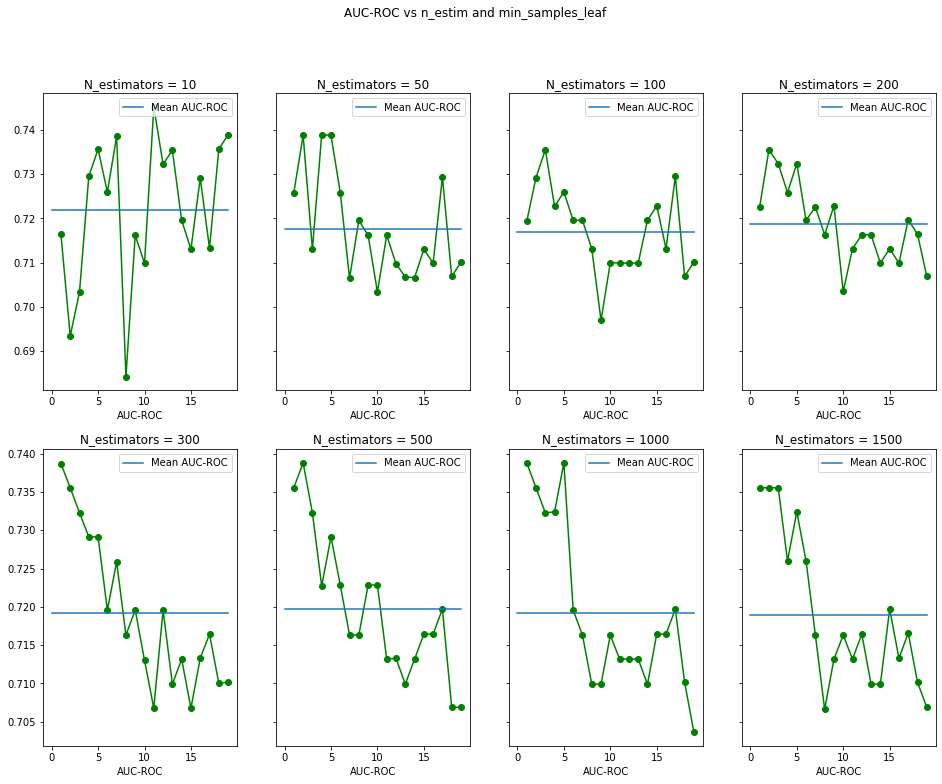

In [481]:
fig, ax = plt.subplots(2, 4, figsize=(16,12), sharey='row')
min_samples = np.arange(1, 20)
n_estimators = np.array([10, 50, 100, 200, 300, 500, 1000, 1500])
c = 0
for i in range(2):
    for j in range(4):
        res = {}
        n_estim = n_estimators[c]
        c += 1
        for leaf in min_samples:
            rf = RandomForestClassifier(n_estimators=n_estim, random_state=6, min_samples_leaf=leaf)
            rf.fit(X_train, y_train)
            res[leaf] = roc_auc_score(y_test, rf.predict(X_test))
        ax[i][j].plot(list(res.keys()), list(res.values()), 'g-o')
        ax[i][j].plot([0, 19], [np.mean(list(res.values())), np.mean(list(res.values()))], label='Mean AUC-ROC')
        ax[i][j].legend()
        ax[i][j].set_title(f'N_estimators = {n_estim}')
        ax[i][j].set_xlabel('min_leaf')
        ax[i][j].set_ylabel('AUC-ROC')
plt.suptitle('AUC-ROC vs n_estim and min_samples_leaf')
plt.show()

Самое большое потенциальное значение достигается для маленького количества базовых моделей. При этом зависимость от mean_samples_leaf для маленьких n_estimators непонятная, похожие значения достигаются и при большом и при маленьком значении этого параметра. При большом количестве базовых моделей маленькие значения min_samples_leaf увеличивают значение метрики - смещение модели уменьшается засчет увеличения глубины, которую можно позволить при таком количестве деревьев без увеличения разброса. 

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим атрибутом случайного леса в библиотеке `sklearn`, чтобы построить `barplot`.

In [482]:
rf = RandomForestClassifier(n_estimators=300, random_state=6)
rf.fit(X_train, y_train)
feat_imp = rf.feature_importances_

In [483]:
feat_imp

array([0.08652984, 0.25723948, 0.08725482, 0.07677684, 0.07858268,
       0.17295776, 0.12152512, 0.11913345])

In [484]:
columns = list(X_train.columns)
columns[6] = 'DPF'

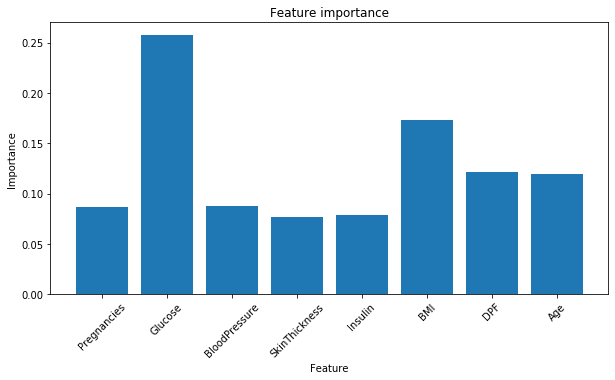

In [485]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(8), feat_imp)
plt.xticks(ticks=np.arange(8), labels=columns, rotation=45)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Самый важный признак - Glucose, дальше идет BMI, на третьем по важности месте - Age и DPF.

**6. (2 балла)** Обучите `HistGradientBoostingClassifier` и `GradientBoostingClassifier` из `sklearn`. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

In [486]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [487]:
searcher_normal = GridSearchCV(GradientBoostingClassifier(random_state=6), param_grid={'n_estimators': n_estimators})
searcher_hist = GridSearchCV(HistGradientBoostingClassifier(random_state=6), param_grid={'max_iter': n_estimators})

In [488]:
%%time
searcher_normal.fit(X_train, y_train)

Wall time: 43 s


GridSearchCV(estimator=GradientBoostingClassifier(random_state=6),
             param_grid={'n_estimators': array([  10,   50,  100,  200,  300,  500, 1000, 1500])})

In [489]:
%%time
searcher_hist.fit(X_train, y_train)

Wall time: 1min 57s


GridSearchCV(estimator=HistGradientBoostingClassifier(random_state=6),
             param_grid={'max_iter': array([  10,   50,  100,  200,  300,  500, 1000, 1500])})

In [490]:
roc_auc_score(y_test, searcher_normal.predict(X_test))

0.7486173956762192

In [491]:
roc_auc_score(y_test, searcher_hist.predict(X_test))

0.7231020613373554

In [492]:
searcher_normal.best_params_

{'n_estimators': 50}

In [493]:
searcher_hist.best_params_

{'max_iter': 10}

In [494]:
metrics(searcher_normal)

Accuracy = 0.7835497835497836
Precision = 0.6944444444444444
Recall = 0.6410256410256411


In [495]:
metrics(searcher_hist)

Accuracy = 0.7705627705627706
Precision = 0.6923076923076923
Recall = 0.5769230769230769


HistGradientBoosting и GradientBoosting решают одинаковую задачу. Основное различие моделей в построении деревьев - GradientBoosting при выборе предиката в очередной вершине перебирает все значения для каждого признака, а HistGradientBoosting строит гистограмму распределения признаков и перебирает граничные значения ее бинов. В теории такой способ построения деревьев должен позволять строить модель быстрее, однако на этом датасете HistGradientBoosting работает медленнее обычного. Кажется, причина этого - маленький размер датасета, из-за которого издержки на построение гистограмм в каждой вершине не перевешиваются издержками на перебор всех возможных значений порогов для признаков, которых не так много. Accuracy и Precision для обоих классификаторов практически одинаковые, roc-auc сильно выше у обычного бустинга, как и Recall.

**7. (1.5 балла)** Вспомните, что представляет из себя стэкинг моделей. Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классификатор из уже вами изученных на курсе. В качестве мета-классификатора (модели, обученной на ответах) используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

В данном пункте мы можете как написать код для стекинга сами, так и использовать [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

In [67]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [68]:
classifiers = [('forest', RandomForestClassifier(n_estimators=300, random_state=6)),
              ('KNN', KNeighborsClassifier(n_neighbors=7, weights='distance'))]

In [80]:
stack = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(random_state=6))
rftest = RandomForestClassifier(n_estimators=300, random_state=6)
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
lr = LogisticRegression(random_state=6)

In [82]:
stack.fit(X_train, y_train)
rftest.fit(X_train, y_train)
knn.fit(X_train, y_train)
lr.fit(X_train, y_train)

C:\Users\79151\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=6)

In [76]:
def scores(model, X_test=X_test, y_test=y_test):
    print(f'Accuracy = {accuracy_score(y_test, model.predict(X_test))}')
    print(f'AUC-ROC = {roc_auc_score(y_test, model.predict(X_test))}')

In [83]:
scores(stack)

Accuracy = 0.7402597402597403
AUC-ROC = 0.6970839617898441


In [84]:
scores(rftest)

Accuracy = 0.7662337662337663
AUC-ROC = 0.7386877828054298


In [85]:
scores(knn)

Accuracy = 0.7142857142857143
AUC-ROC = 0.6837606837606839


In [86]:
scores(lr)

Accuracy = 0.7835497835497836
AUC-ROC = 0.7423328305681247


Стэкинг сработал грустно, предсказания логистической регрессии без него работают гораздо лучше. Стэкинг был составлен из 3 моделей - случайного леса, knn и логистической регрессии. Возможно, причина провала стэкинга именно использование knn. потому что это единственная модель, у которой качество при использовании ее отдельно ниже, чем у стэкинга.